# Model and Sample Evaluation

We evaluating samples by first, **applying a predicate** over the dataset, then, **computing aggregates (mean, median, sum and count)** over the samples. We will then take the average over all the errors. 

> We use the relative error to compute error between two output. See below under Error.

In this notebook, the predicates are divided into different groups based on attributes and ops. The averages are also take across the particular group and the selected metrics.

This notebook allows you to conduct test on the model by running experiments on the samples generated. You will need

1. The actual dataset (full yelp dataset in this case)
2. The generated samples

Both files need to be in csv format. 

## Importing Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import random
import math
from prettytable import PrettyTable
random.seed(30)
np.random.seed(39)

## File Paths

In [2]:
original_dataset_file = '../../datasets/yelp_business.csv'
generated_sample_file = './samples/vae_3_sample_10000.csv'

## Functions for experiments

### Load Samples
Loads the datasets for evaluation. 
1. VAE Generated Samples (Pandas DF)
2. Randomly selected Samples from original dataset (Pandas DF)
3. Full dataset (Pandas DF)
4. Full dataset (NumPy)

You are are allowed to specify the number of samples you wish to use for the test. This function will then randomly select that amount of samples from both the original VAE generated dataset and original True dataset for the VAE Generated Samples and Randomly Selected Samples respectively.

In [3]:
def load_samples(number_of_samples):
    generated_sample = np.genfromtxt(generated_sample_file, delimiter = ',', skip_header=1)
    real_data = np.genfromtxt(original_dataset_file, delimiter = ',', skip_header=1)
    real_sample = real_data[np.random.choice(len(real_data), size=number_of_samples, replace=False)]
    generated_sample = generated_sample[np.random.choice(len(generated_sample), size=number_of_samples, replace=False)]

    generated = pd.DataFrame(generated_sample, columns = ['latitude','longitude','stars','review_count','is_open'])
    real_dataset = pd.DataFrame(real_data, columns = ['latitude','longitude','stars','review_count','is_open'])
    real_sample = pd.DataFrame(real_sample, columns = ['latitude','longitude','stars','review_count','is_open'])

    return generated, real_sample, real_dataset, real_data

### Generate Spatial Range Predicates
Will generate a list of spatial predicates and return the list. Predicates will be range spatial predicates. Specify actual dataset and number of samples

In [4]:
def generate_spatial_range_predicates(real_data, number_of_samples=100):
	sample = real_data[np.random.choice(len(real_data), size=number_of_samples, replace=False)]
	predicates = []
	for i in sample:
		coordinate = tuple(i[:2])
		radius = random.uniform(0, 1)
		predicates.append([('coordinates', 'range',(coordinate, radius))])
	return predicates

### Generate Normal Predicates

Generating a dict of predicates arranged in a hierarchical order. The ends contain a list of predicates.

```python
predicate_dict ---- Stars ______________  == (equality)
            |           |_______________  >= (more than or equals)
            |           |_______________  <= (less than or equals)
            | 
            |  ----- Review_count ______ == (equality)
            |           |_______________  >= (more than or equals)
            |           |_______________  <= (less than or equals)
            |
            | ----- is_open _____________ == (equality)
```      


```python
{'stars':{'==':[], '>=':[], '<=':[]}, 'review_count':{'==':[], '>=':[], '<=':[]}, 'is_open':{'==':[], '>=':[], '<=':[]}}
```



In [5]:
def generate_normal_predicates(real_data, number_of_samples):
    ops_dict = {0:'==', 1:'>=', 2:'<='}
    predicate_dict = {'stars':{'==':[], '>=':[], '<=':[]}, 'review_count':{'==':[], '>=':[], '<=':[]}, 'is_open':{'==':[], '>=':[], '<=':[]}}
    reverse_categorical_map = {0:0, 1:0.5, 2:1, 3:1.5, 4:2, 5:2.5, 6:3, 7:3.5, 8:4, 9:4.5, 10:5}
    minimum_review, maximum_review  = int(min(list(real_data[3]))), int(max(list(real_data[3])))

    # stars
    for _ in range((number_of_samples-2)//2):
        ops = random.randint(0, 2)
        value = reverse_categorical_map[random.randint(0, 10)]
        predicate_dict['stars'][ops_dict[ops]].append([('stars', ops_dict[ops], value)])

    # reviews
    for _ in range((number_of_samples-2)//2):
        ops = random.randint(0, 2)
        value = random.randint(minimum_review, maximum_review)
        predicate_dict['review_count'][ops_dict[ops]].append([('review_count', ops_dict[ops], value)])

    predicate_dict['is_open']['=='].append([('is_open', '==', 1)])
    predicate_dict['is_open']['=='].append([('is_open', '==', 0)])
    return predicate_dict

### In Radius 

This is to faciliate the spatial range predicates. It true or false depending on whether the target coordinate is within a certain radius of the chosen center. 

In [6]:
def in_radius(coordinate, center, radius):
	return np.linalg.norm(np.array(coordinate)-np.array(center)) <= radius

### Evaluation Functions
The functions below helps us to evaluate the performance of the samples.

- Call **evaluate_dataset** to evaluate the performance of a dataset (in this case, randomly drawn samples/ generated samples) with respect to the actual dataset.
- Call **compare_evaluate_dataset** to compare the performance of two datasets with respect to the actual dataset
- Call **evaluate_query** to compute the aggregates of dataset for a specific predicate

In [7]:
# evaluation for 1 query
def evaluate_query(dataset ,predicates):
    dataset.reset_index(drop=True)
    for predicate in predicates:
        attribute, op, value = predicate
        if attribute == 'coordinates':
            selection =	np.array(np.ones(len(dataset)), dtype='bool')
            for index, row in dataset.iterrows():
                selection[index] = in_radius((row[0], row[1]), value[0], value[1])
            dataset = dataset[selection]
            dataset.reset_index(drop=True)
        else:
            dataset = dataset.query(attribute+op+str(value))
            dataset.reset_index(drop=True)
    results = dataset.agg(['mean', 'median','count','sum'])
    return results

In [8]:
# evaluating loss for 1 predicate
def evaluate_predicate(real_dataset, test_dataset, predicates, error_dict):
    real_results = evaluate_query(real_dataset, predicates)
    test_results = evaluate_query(test_dataset, predicates)
    no_samples = False
    
    for a in test_results.keys():
        if test_results[a]['count'] == 0:
            no_samples = True
    if no_samples:
        print('NO SAMPLES FOR THIS PREDICATE :', predicates)
    multiplier = len(real_dataset)/len(test_dataset)
    test_results['stars']['count'] = test_results['stars']['count']*multiplier
    test_results['stars']['sum'] = test_results['stars']['sum']*multiplier
    test_results['review_count']['count'] = test_results['review_count']['count']*multiplier
    test_results['review_count']['sum'] = test_results['review_count']['sum']*multiplier
    test_results['is_open']['count'] = test_results['is_open']['count']*multiplier
    test_results['is_open']['sum'] = test_results['is_open']['sum']*multiplier
    
    compute_error(real_results, test_results, error_dict)

In [9]:
def evaluate_dataset(real_dataset, test_dataset, predicates_dict):
    for a in predicates_dict.keys():
        for op in predicates_dict[a].keys():
            print(real_dataset.shape, test_dataset.shape)
            print('Evaluating Error for ' + str(a) + ' and ' + str(op))
            error_dict = {'stars':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'review_count':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'is_open':{'sum':[], 'mean':[], 'count':[]}}
            error_dict = evaluate_helper(real_dataset, test_dataset, predicates_dict[a][op], error_dict)
            error_summary = {'stars':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'review_count':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'is_open':{'sum':'na', 'mean':'na', 'count':'na', 'median':'na'}}
            for a2 in error_dict.keys():
                for m in error_dict[a2].keys():
                    if len(error_dict[a2][m])>0:
                        error_summary[a2][m] = sum(error_dict[a2][m])/len(error_dict[a2][m])
            display_results(error_summary)
            
def evaluate_helper(real_dataset, test_dataset, predicates_list, error_dict=None):
    if error_dict is None:
        error_dict = {'stars':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'review_count':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'is_open':{'sum':[], 'mean':[], 'count':[]}}
    for predicates in predicates_list:
        evaluate_predicate(real_dataset, test_dataset, predicates, error_dict)
    return error_dict
            

In [10]:
def compare_evaluate_dataset(real_dataset, test_dataset_1, test_dataset_2, predicates_dict):
    for a in predicates_dict.keys():
        for op in predicates_dict[a].keys():
            print(real_dataset.shape, test_dataset_1.shape, test_dataset_2.shape)
            print('Evaluating Error for ' + str(a) + ' and ' + str(op))
            error_dict_1 = {'stars':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'review_count':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'is_open':{'sum':[], 'mean':[], 'count':[]}}
            error_dict_2 = {'stars':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'review_count':{'sum':[], 'mean':[], 'median':[], 'count':[]}, 'is_open':{'sum':[], 'mean':[], 'count':[]}}
            error_dict_1 = evaluate_helper(real_dataset, test_dataset_1, predicates_dict[a][op], error_dict_1)
            error_dict_2 = evaluate_helper(real_dataset, test_dataset_2, predicates_dict[a][op], error_dict_2)
            error_summary_1 = {'stars':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'review_count':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'is_open':{'sum':'na', 'mean':'na', 'count':'na', 'median':'na'}}
            error_summary_2 = {'stars':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'review_count':{'sum':'na', 'mean':'na', 'median':'na', 'count':'na'}, 'is_open':{'sum':'na', 'mean':'na', 'count':'na', 'median':'na'}}
            for a2 in error_dict_1.keys():
                for m in error_dict_1[a2].keys():
                    if len(error_dict_1[a2][m])>0:
                        error_summary_1[a2][m] = sum(error_dict_1[a2][m])/len(error_dict_1[a2][m])
            for a2 in error_dict_2.keys():
                for m in error_dict_2[a2].keys():
                    if len(error_dict_2[a2][m])>0:
                        error_summary_2[a2][m] = sum(error_dict_2[a2][m])/len(error_dict_2[a2][m])
            display_compare_results(error_summary_1, error_summary_2)

def display_compare_results(error_summary_1, error_summary_2):
    x = PrettyTable()
    
    column_names = ["errors"] + ["stars", "review_count", "is_open"] + ["next_model"] + ["stars", "review_count", "is_open"]

    x.add_column(column_names[0], ["mean", "median", "sum", 
        "count"])
    i = 1
    for a in error_summary_1.keys():
        x.add_column(column_names[i], [display_helper(error_summary_1[a]['mean']), display_helper(error_summary_1[a]['median']), display_helper(error_summary_1[a]['sum']), display_helper(error_summary_1[a]['count'])])  
        i += 1
    x.add_column(column_names[i], [" ", " ", " ", 
        " "])
    i+= 1
    for a in error_summary_2.keys():
        x.add_column(column_names[i], [display_helper(error_summary_2[a]['mean']), display_helper(error_summary_2[a]['median']), display_helper(error_summary_2[a]['sum']), display_helper(error_summary_2[a]['count'])])  
        i += 1
    print(x)

def display_helper(number):
    if number == 'na':
        return number
    return_number = number * 100
    return_number = round(return_number, 2)
    return return_number


In [11]:
def display_results(error_summary, metric='mean'):
    x = PrettyTable()
    
    column_names = ["errors", "stars", "review_count", "is_open"]

    x.add_column(column_names[0], ["mean", "median", "sum", 
        "count"])
    i = 1
    for a in error_summary.keys():
        x.add_column(column_names[i],[display_helper(error_summary[a]['mean']), display_helper(error_summary[a]['median']), display_helper(error_summary[a]['sum']), display_helper(error_summary[a]['count'])])  
        i += 1
    print(x)

In [12]:
def selectivity_filter(lower_percentage, higher_percentage, predicates_list, dataset):
    dataset.reset_index(drop=True)
    original_size = dataset.size
    new_predicates_list = []
    for predicates in predicates_list:
        new_dataset = dataset
        for predicate in predicates:
            attribute, op, value = predicate
            if attribute == 'coordinates':
                selection = np.array(np.ones(len(new_dataset)), dtype='bool')
                for index, row in dataset.iterrows():
                    selection[index] = in_radius((row[0], row[1]), value[0], value[1])
                new_dataset = new_dataset[selection]
                new_dataset.reset_index(drop=True)
            else:
                new_dataset = new_dataset.query(attribute+op+str(value))
                new_dataset.reset_index(drop=True)
        
        count = new_dataset.size
        
        if count/original_size > lower_percentage and count/original_size <= higher_percentage:
            new_predicates_list.append(predicates)

    return new_predicates_list

### Error Function 
Error between an approximate and actual results are measured using the following equation:
![relative_error_equation](miscellaneous/relative_error_equation.png)
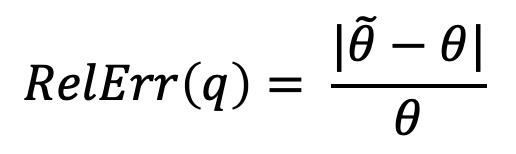

In [13]:
def error(y_true, y_pred):
    if math.isnan(y_pred) or math.isnan(y_true):
        return 1
    return abs(y_true-y_pred)/(y_true+1)

# compute loss for 1 query, returns error dictionary for storing errrors
def compute_error(real_results, test_results, error_dict):
    for a in error_dict.keys():
        for m in error_dict[a].keys():
            error_dict[a][m].append(error(real_results[a][m], test_results[a][m]))
    return error_dict

In [14]:
generated_sample, real_sample, real_dataset, real_data = load_samples(2000)
normal_predicates = generate_normal_predicates(real_data, 200)

for a in normal_predicates.keys():
    for op in normal_predicates[a].keys():
        normal_predicates[a][op] = selectivity_filter(0.01, 1, normal_predicates[a][op], real_dataset)

In [15]:
generated_sample.shape

(2000, 5)

### Results

### Evaluating Generated Samples

In [27]:
evaluate_dataset(real_dataset, generated_sample, normal_predicates)

(174567, 5) (2000, 5)
Evaluating Error for stars and ==
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+---------+
|  mean  |  0.0  |    31.27     |   3.03  |
| median |  0.0  |    26.52     |    na   |
|  sum   |  7.53 |    30.26     |   8.49  |
| count  |  7.53 |     7.53     |   7.53  |
+--------+-------+--------------+---------+
(174567, 5) (2000, 5)
Evaluating Error for stars and >=
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+---------+
|  mean  |  0.57 |    42.97     |   0.8   |
| median |  1.75 |    25.13     |    na   |
|  sum   |  1.97 |    45.18     |   2.22  |
| count  |  1.27 |     1.27     |   1.27  |
+--------+-------+--------------+---------+
(174567, 5) (2000, 5)
Evaluating Error for stars and <=
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+-------

### Evaluating Random Samples

In [28]:
evaluate_dataset(real_dataset, real_sample, normal_predicates)

(174567, 5) (2000, 5)
Evaluating Error for stars and ==
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+---------+
|  mean  |  0.0  |    13.11     |   1.03  |
| median |  0.0  |    10.31     |    na   |
|  sum   |  5.43 |    15.45     |   6.57  |
| count  |  5.43 |     5.43     |   5.43  |
+--------+-------+--------------+---------+
(174567, 5) (2000, 5)
Evaluating Error for stars and >=
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+---------+
|  mean  |  0.47 |     5.36     |   0.33  |
| median |  2.5  |     2.38     |    na   |
|  sum   |  1.35 |     4.9      |   0.93  |
| count  |  0.78 |     0.78     |   0.78  |
+--------+-------+--------------+---------+
(174567, 5) (2000, 5)
Evaluating Error for stars and <=
+--------+-------+--------------+---------+
| errors | stars | review_count | is_open |
+--------+-------+--------------+-------

### Comparing Performance Of Above 2
Generated samples on the left, and real samples on the right.

In [16]:
compare_evaluate_dataset(real_dataset, generated_sample, real_sample, normal_predicates)

(174567, 5) (2000, 5) (2000, 5)
Evaluating Error for stars and ==
+--------+-------+--------------+---------+------------+-------+--------------+---------+
| errors | stars | review_count | is_open | next_model | stars | review_count | is_open |
+--------+-------+--------------+---------+------------+-------+--------------+---------+
|  mean  |  0.0  |    32.49     |   2.73  |            |  0.0  |    14.33     |   1.43  |
| median |  0.0  |     25.9     |    na   |            |  0.0  |     7.05     |    na   |
|  sum   |  8.7  |    34.17     |  11.15  |            |  5.8  |    14.19     |   7.43  |
| count  |  8.7  |     8.7      |   8.7   |            |  5.8  |     5.8      |   5.8   |
+--------+-------+--------------+---------+------------+-------+--------------+---------+
(174567, 5) (2000, 5) (2000, 5)
Evaluating Error for stars and >=
+--------+-------+--------------+---------+------------+-------+--------------+---------+
| errors | stars | review_count | is_open | next_model | s

### Computing Aggregates For A Single Predicate

For the target predicate below,

In [38]:
normal_predicates['stars']['=='][2]

[('stars', '==', 1)]

#### computes the aggregates by `calling evaluate_query`

In [31]:
evaluate_query(generated_sample, normal_predicates['stars']['=='][2])

,latitude,longitude,stars,review_count,is_open
mean,37.768078,-97.847361,1.0,4.98,0.76
median,36.163956,-110.633859,1.0,4.00,1.00
count,50.000000,50.000000,50.0,50.00,50.00
sum,1888.403912,-4892.368071,50.0,249.00,38.00


In [32]:
evaluate_query(real_dataset, normal_predicates['stars']['=='][2])

,latitude,longitude,stars,review_count,is_open
mean,37.868712,-96.615644,1.0,5.81679,0.891499
median,36.118778,-111.728964,1.0,3.00000,1.000000
count,3788.000000,3788.000000,3788.0,3788.00000,3788.000000
sum,143446.681774,-365980.059602,3788.0,22034.00000,3377.000000


In [33]:
evaluate_query(real_sample, normal_predicates['stars']['=='][2])

,latitude,longitude,stars,review_count,is_open
mean,38.310937,-95.224187,1.0,4.534884,0.906977
median,36.216772,-82.039882,1.0,3.000000,1.000000
count,43.000000,43.000000,43.0,43.000000,43.000000
sum,1647.370307,-4094.640051,43.0,195.000000,39.000000


In [34]:
evaluate_query(generated_sample, [])

,latitude,longitude,stars,review_count,is_open
mean,38.241895,-94.062789,3.588,16.127,0.8485
median,36.139621,-109.224904,3.500,6.000,1.0000
count,2000.000000,2000.000000,2000.000,2000.000,2000.0000
sum,76483.789967,-188125.578280,7176.000,32254.000,1697.0000


In [35]:
evaluate_query(real_dataset, [])

,latitude,longitude,stars,review_count,is_open
mean,3.862731e+01,-9.267901e+01,3.632196,3.013706e+01,0.840376
median,3.614426e+01,-8.941013e+01,3.500000,8.000000e+00,1.000000
count,1.745660e+05,1.745660e+05,174567.000000,1.745670e+05,174567.000000
sum,6.743015e+06,-1.617860e+07,634061.500000,5.260936e+06,146702.000000


In [36]:
evaluate_query(real_sample, [])

,latitude,longitude,stars,review_count,is_open
mean,38.821916,-91.581528,3.66475,29.3185,0.8325
median,36.157982,-89.305639,4.00000,8.0000,1.0000
count,2000.000000,2000.000000,2000.00000,2000.0000,2000.0000
sum,77643.832785,-183163.055070,7329.50000,58637.0000,1665.0000
